In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import log

import cobra
import cplex
from cobra.io import read_sbml_model, load_matlab_model
from cobra.flux_analysis import flux_variability_analysis

from helpers import *

# Genome-scale model

In [56]:
fluxes = pd.read_csv("flux_data.csv")

## Compare objective functions

In [37]:
model = load_model()
evaluate_objective(model, fluxes, objective="biomass")

Linear objective, running flux variability analysis...


/home/danbobr/miniconda3/envs/systbio/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/home/danbobr/miniconda3/envs/systbio/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Fluxes are variable.
Maximizing and minimizing predictive fidelity...
Running parsimonious FBA...


,objective,method,reaction_set,Batch_06,Batch_03,Batch_02,Chem_01,Chem_04C,Chem_04N
0,biomass,fidmax,total,NaN,NaN,NaN,NaN,NaN,NaN
1,biomass,fidmax,shuetz,NaN,NaN,NaN,NaN,NaN,NaN
2,biomass,fidmin,total,0.027821,0.194821,0.197852,0.042988,0.030418,0.152467
3,biomass,fidmin,shuetz,0.060606,0.231230,0.148046,0.099560,0.027714,0.011274
4,biomass,pfba,total,0.040904,0.280497,0.215329,0.044803,0.033827,0.153868
5,biomass,pfba,shuetz,0.111769,0.639467,0.293429,0.105713,0.030461,0.014943


In [38]:
model = load_model()
evaluate_objective(model, fluxes, objective="ATP")

Linear objective, running flux variability analysis...
Fluxes are variable.
Maximizing and minimizing predictive fidelity...
Running parsimonious FBA...


,objective,method,reaction_set,Batch_06,Batch_03,Batch_02,Chem_01,Chem_04C,Chem_04N
0,ATP,fidmax,total,NaN,NaN,NaN,NaN,NaN,NaN
1,ATP,fidmax,shuetz,NaN,NaN,NaN,NaN,NaN,NaN
2,ATP,fidmin,total,0.371375,1.638162,2.558195,0.050376,0.104007,0.209967
3,ATP,fidmin,shuetz,0.049844,0.040944,0.018915,0.047765,0.023753,0.001804
4,ATP,pfba,total,0.436588,1.772064,2.585562,0.074370,0.132400,0.255262
5,ATP,pfba,shuetz,0.146518,0.535283,0.190122,0.089972,0.039499,0.010697


In [39]:
model = load_model()
evaluate_objective(model, fluxes, objective="minfluxsq")

Quadratic objective, so fluxes aren't variable.


,objective,method,reaction_set,Batch_06,Batch_03,Batch_02,Chem_01,Chem_04C,Chem_04N
0,minfluxsq,fba,total,0.260109,0.446945,0.148298,0.164692,0.200793,0.039971
1,minfluxsq,fba,shuetz,0.287880,0.953376,0.679014,0.188373,0.072677,0.031847


In [42]:
model = load_model()
evaluate_objective(model, fluxes, objective="minfluxabs")

Quadratic objective, so fluxes aren't variable.


,objective,method,reaction_set,Batch_06,Batch_03,Batch_02,Chem_01,Chem_04C,Chem_04N
0,minfluxabs,fba,total,0.260109,0.446945,0.148298,0.164692,0.200793,0.039971
1,minfluxabs,fba,shuetz,0.287880,0.953376,0.679014,0.188373,0.072677,0.031847


In [ ]:
model = load_model()
evaluate_objective(model, fluxes, objective="ATPperflux")

In [ ]:
model = load_model()
evaluate_objective(model, fluxes, objective="biomassperflux")

## Biomass objective

In [7]:
ratios = []
for i in range(fluxes.shape[0]):
    reaction = fluxes["iAF1260"][i]
    metabolite = fluxes["Metab_norm"][i]
    ratios.append(calculate_split_ratio(model, reaction, metabolite))
fluxes["ratio"] = ratios

In [8]:
# print ratios that are below 0 or above 1
fluxes.ratio[(fluxes["ratio"] < 0) | (fluxes["ratio"] > 1.00000001)]

Series([], Name: ratio, dtype: float64)

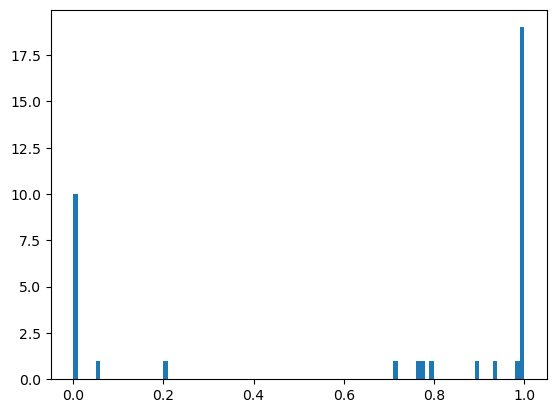

In [9]:
plt.hist(fluxes["ratio"], bins=100)
plt.show()

# Model from the paper

In [2]:
model = read_sbml_model("EcoliModel.xml")

In [38]:
irreversible = ["glk", "pfkA", "pfkB", "pykF", "pykA", "aceEF",
                "maeB", "maeA", "pck", "fbp", "glpX", "pps",
                "pgl", "gnd", "gltA", "prpC", "sucAB", "mqo",
                "aceB", "ppc", "pntAB", "udhA", "atp", "nuo",
                "ndh", "cyoABCD", "cydAB", "narGHI", "poxB",
                "fdhF", "fdoGHI", "fdnGHI_r2", "pta", "acs",
                "dld", "edd", "eda", "mgsA", "ptsGHI", "co2",
                "o2", "no3", "no2", "succ", "lac", "pyr", "focA",
                "mglABC", "maint", "biomass"]

count = 0
for reaction in model.reactions:
    if reaction.id in irreversible:
        count += 1
        reaction.lower_bound = 0
    if reaction.check_mass_balance() != {}:
        print(reaction.id, reaction.check_mass_balance())
    print(reaction)

glk: ATP + GLC --> G6P
pgi: G6P <=> F6P
pfkA: ATP + F6P --> FDP
pfkB: ATP + F6P --> FDP
fbaA: FDP <=> DHAP + GA3P
fbaB: FDP <=> DHAP + GA3P
tpiA: DHAP <=> GA3P
gapA: GA3P <=> NADH + _13DPG
pgk: _13DPG <=> ATP + _3PG
gpmA: _3PG <=> _2PG
gpmB: _3PG <=> _2PG
eno: _2PG <=> PEP
pykF: PEP --> ATP + PYR
pykA: PEP --> ATP + PYR
aceEF: COA + PYR --> ACCOA + CO2 + NADH
maeB: MAL --> CO2 + NADPH + PYR
maeA: MAL --> CO2 + NADH + PYR
pck: ATP + OA --> CO2 + PEP
fbp: FDP --> F6P
glpX: FDP --> F6P
pps: 2.0 ATP + PYR --> PEP
zwf: G6P <=> D6PGL + NADPH
pgl: D6PGL --> _6PGC
gnd: _6PGC --> CO2 + NADPH + RL5P
rpiA: RL5P <=> R5P
rpiB: RL5P <=> R5P
rpe: RL5P <=> X5P
tktA: R5P + X5P <=> GA3P + S7P
tktB: R5P + X5P <=> GA3P + S7P
tktA_r2: E4P + X5P <=> F6P + GA3P
tktB_r2: E4P + X5P <=> F6P + GA3P
talA: GA3P + S7P <=> E4P + F6P
talB: GA3P + S7P <=> E4P + F6P
gltA: ACCOA + OA --> CIT + COA
prpC: ACCOA + OA --> CIT + COA
acnA: CIT <=> CAC
acnA_r2: CAC <=> ICIT
acnB: CIT <=> CAC
acnB_r2: CAC <=> ICIT
icd: ICIT <=>

In [27]:
model.reactions.get_by_id("biomass")

Reaction identifier,biomass
Name,biomass
Memory address,0x7f01d27f1f70
Stoichiometry,2.41 ACCOA + 1.28 AKG + 40.2 ATP + 0.36 E4P + 0.07 F6P + 0.33 G6P + 0.12 GA3P + 15.7 NADPH + 1.65 OA + 0.77 PEP + 2.94 PYR + 0.96 R5P + 0.86 _3PG --> BM + 2.41 COA + 3.0 NADH 2.41 ACCOA + 1.28 AKG + 40.2 ATP + 0.36 E4P + 0.07 F6P + 0.33 G6P + 0.12 GA3P + 15.7 NADPH + 1.65 OA + 0.77 PEP + 2.94 PYR + 0.96 R5P + 0.86 3PG --> BM + 2.41 COA + 3.0 NADH
GPR,
Lower bound,0
Upper bound,1000.0


In [28]:
model.reactions.get_by_id("biomass").subtract_metabolites({
    model.metabolites.get_by_id("COA"): 2.41,
})
model.reactions.get_by_id("biomass").add_metabolites({
    model.metabolites.get_by_id("GA3P"): -0.24,
})

In [29]:
model.reactions.get_by_id("biomass")

Reaction identifier,biomass
Name,biomass
Memory address,0x7f01d27f1f70
Stoichiometry,2.41 ACCOA + 1.28 AKG + 40.2 ATP + 0.36 E4P + 0.07 F6P + 0.33 G6P + 0.36 GA3P + 15.7 NADPH + 1.65 OA + 0.77 PEP + 2.94 PYR + 0.96 R5P + 0.86 _3PG --> BM + 3.0 NADH 2.41 ACCOA + 1.28 AKG + 40.2 ATP + 0.36 E4P + 0.07 F6P + 0.33 G6P + 0.36 GA3P + 15.7 NADPH + 1.65 OA + 0.77 PEP + 2.94 PYR + 0.96 R5P + 0.86 3PG --> BM + 3.0 NADH
GPR,
Lower bound,0
Upper bound,1000.0


In [30]:
for metab in model.metabolites:
    metab_reactions = [react.id for react in metab.reactions]
    print(f"Metabolite: {metab.name}, reactions: {metab_reactions}")

Metabolite: GLC, reactions: ['glk', 'mglABC']
Metabolite: ATP, reactions: ['pgk', 'pps', 'maint', 'ackB', 'atp', 'acs', 'pfkA', 'purT', 'pykA', 'sucCD', 'ackA', 'pfkB', 'glk', 'pykF', 'pck', 'biomass', 'tdcD']
Metabolite: G6P, reactions: ['glk', 'zwf', 'ptsGHI', 'biomass', 'pgi']
Metabolite: F6P, reactions: ['tktB_r2', 'fbp', 'pfkB', 'talA', 'talB', 'tktA_r2', 'biomass', 'glpX', 'pfkA', 'pgi']
Metabolite: FDP, reactions: ['pfkB', 'fbaA', 'glpX', 'fbp', 'pfkA', 'fbaB']
Metabolite: DHAP, reactions: ['fbaA', 'tpiA', 'fbaB', 'mgsA']
Metabolite: GA3P, reactions: ['tpiA', 'tktB_r2', 'gapA', 'tktB', 'fbaA', 'eda', 'talA', 'talB', 'tktA_r2', 'biomass', 'fbaB', 'tktA']
Metabolite: NADH, reactions: ['sucAB', 'mdh', 'adhE_r2', 'adhC', 'gapA', 'adhP', 'fdhF', 'fdnGHI_r2', 'fdoGHI', 'aceEF', 'nuo', 'mhpF', 'adhE', 'pntAB', 'udhA', 'ndh', 'ldhA', 'biomass', 'maeA']
Metabolite: 13DPG, reactions: ['pgk', 'gapA']
Metabolite: 3PG, reactions: ['pgk', 'gpmB', 'gpmA', 'biomass']
Metabolite: 2PG, reactions:

In [31]:
model.boundary

[]

In [32]:
model.objective = "biomass"

In [33]:
print(model.objective.expression)
print(model.objective.direction)

1.0*biomass - 1.0*biomass_reverse_01e59
max


In [36]:
model.optimize()

,fluxes,reduced_costs
glk,0.0,-1.573667e-02
pgi,0.0,-2.678732e-18
pfkA,0.0,-0.000000e+00
pfkB,0.0,0.000000e+00
fbaA,0.0,0.000000e+00
...,...,...
pyr,0.0,0.000000e+00
focA,0.0,0.000000e+00
mglABC,0.0,-1.311389e-02
maint,0.0,-5.245558e-02


In [12]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
Metabolite,Reaction,Flux,C-Number,C-Flux


In [15]:
model.metabolites.ATP.summary()

Percent,Flux,Reaction,Definition
Percent,Flux,Reaction,Definition
